# Rainfall script

First let's import necessary packages:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import dew_gwdata as gd
import wrap_technote as tn

plt.rcParams["figure.dpi"] = 100

Let's also configure things so we can see some information about how things are going:

In [2]:
from loguru import logger
import sys

_ = logger.add(sys.stdout, level="INFO")

We will use the WMLR report as an example:

In [3]:
report = tn.load_report("WMLR", rperiod="2021-22")

Everything works by iteration over the rainfall stations that are defined for the WMLR report:

In [4]:
stations = report.read_table("Report_Rainfall_stations")
stations

,comments,data_start,filename,mean_period_finish,mean_period_start,previous_users,report,rf_period_finish,rf_period_start,station_id,station_name,station_type
48,NaN,1950-01-01,Report_Rainfall_stations.xlsx,2021-06-30,1973-07-01,GW,WMLR,2021-09-30,2020-07-01,23823,Hindmarsh Valley,BoM
49,NaN,1950-01-01,Report_Rainfall_stations.xlsx,2021-06-30,1973-07-01,GW,WMLR,2021-09-30,2020-07-01,23750,Uraidla,BoM
50,NaN,1950-01-01,Report_Rainfall_stations.xlsx,2021-06-30,1973-07-01,SW,WMLR,2021-09-30,2020-07-01,23734,Mount Bold Reservoir,BoM
51,NaN,1950-01-01,Report_Rainfall_stations.xlsx,2021-06-30,1973-07-01,SW,WMLR,2021-09-30,2020-07-01,23731,Cudlee Creek,BoM
52,NaN,1950-01-01,Report_Rainfall_stations.xlsx,2021-06-30,1973-07-01,SW,WMLR,2021-09-30,2020-07-01,23737,Mount Pleasant,BoM
53,NaN,1950-01-01,Report_Rainfall_stations.xlsx,2021-06-30,1973-07-01,SW,WMLR,2021-09-30,2020-07-01,23754,Yankalilla,BoM
54,NaN,1950-01-01,Report_Rainfall_stations.xlsx,2021-06-30,1973-07-01,SW,WMLR,2021-09-30,2020-07-01,23742,Port Elliot,BoM


For the example here let's use Mount Pleasant - station ID 23737.

In [5]:
rrow = report.rainfall_dfn(23737)
rrow

comments                                        NaN
data_start                      1950-01-01 00:00:00
filename              Report_Rainfall_stations.xlsx
mean_period_finish              2021-06-30 00:00:00
mean_period_start               1973-07-01 00:00:00
previous_users                                   SW
report                                         WMLR
rf_period_finish                2021-09-30 00:00:00
rf_period_start                 2020-07-01 00:00:00
station_id                                    23737
station_name                         Mount Pleasant
station_type                                    BoM
Name: 52, dtype: object

Download data:

In [6]:
rf = tn.RainfallStationData.from_bom_via_silo(rrow.station_id, data_start=rrow.data_start)
rf

station #: 23737 name: MOUNT PLEASANT title: 23737 MOUNT PLEASANT (fetched from SILO on 2022-10-31 11:29:43.145839)


Now let's save all this data to disk so we don't have to download it every time.

In [7]:
rf.save_to_excel(report, overwrite=True)

In [8]:
rf.save_to_database(report)

2022-10-31 11:29:49.613 | INFO     | wrap_technote.rainfall:save_to_database:248 - Saving 'daily'
2022-10-31 11:29:49.783 | INFO     | wrap_technote.rainfall:save_to_database:253 - Joined existing stations to 23737
<class 'pandas.core.frame.DataFrame'>
Int64Index: 53202 entries, 0 to 26601
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               53202 non-null  object 
 1   rainfall           53202 non-null  float64
 2   interpolated_code  53202 non-null  int64  
 3   quality            53202 non-null  int64  
 4   year               53202 non-null  int64  
 5   dayofyear          53202 non-null  int64  
 6   finyear            53202 non-null  object 
 7   station_id         53202 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 3.7+ MB
2022-10-31 11:29:49.802 | INFO     | wrap_technote.rainfall:save_to_database:262 - None
date
object
datetime64[ns]
rainfall
float64
flo

KeyError: 'date'

Find all wells in the resource which could possibly have the minimum amount of data (usually at least two data points).

In [4]:
wells = resource.find_wells()
len(wells)

24

What is the query that's used in the background? It's SQL which is generated based on the type of data (water level in this case) and the time period for which the analysis will be done:

In [5]:
query = resource.well_selection_query
sql = query.sql(parameter="WL", start_year=2017, end_year=2021)

Here's the last part of the SQL, for interest's sake:

In [6]:
print("...")
print(sql[sql.find("FROM") :])

...
FROM dhdb.dd_drillhole_vw dh
    INNER JOIN dhdb.dd_drillhole_summary_vw summ ON dh.drillhole_no = summ.drillhole_no
    INNER JOIN dhdb.dd_drillhole_geodetic_vw gd ON dh.drillhole_no = gd.drillhole_no
    LEFT JOIN dhdb.dd_dh_group_vw gdh ON dh.drillhole_no = gdh.drillhole_no
    INNER JOIN
    (SELECT drillhole_no,
            Count(*) AS n_obs
    FROM
        (SELECT drillhole_no
        FROM dhdb.wa_water_level_vw
        WHERE obs_date BETWEEN date '2017-01-01' AND date '2021-12-31'
            AND series_type = 'T'
            AND (depth_to_water IS NOT NULL OR standing_water_level IS NOT NULL OR rswl IS NOT NULL) )
    GROUP BY drillhole_no
    HAVING Count(*) >= 5) subquery ON dh.drillhole_no = subquery.drillhole_no
    WHERE dh.presc_water_res_area_code = 'Barossa Valley' and (summ.aq_subaq = 'Tomr')


Did the definition include replacement wells?

In [7]:
query.include_replacements

False

OK - so what were the wells that may have data?

In [8]:
wells

,well_id,dh_no,unit_long,unit_hyphen,obs_no,dh_name,easting,northing,zone,latitude,longitude,aquifer,pwa,pwra
0,MOR062,53000,662806031,6628-6031,MOR062,MESA,314334.64,6178583.55,54,-34.517691,138.977297,Tomr,None,Barossa Valley
1,MOR201,61297,662814328,6628-14328,MOR201,MESA - OBS,312604.65,6173313.53,54,-34.564872,138.957300,Tomr,None,Barossa Valley
2,MOR202,62362,662815393,6628-15393,MOR202,MESA,314698.70,6176262.52,54,-34.538674,138.980756,Tomr,None,Barossa Valley
3,MOR203,62363,662815394,6628-15394,MOR203,None,314700.67,6176269.55,54,-34.538612,138.980779,Tomr,None,Barossa Valley
4,MOR206,64601,662901458,6629-1458,MOR206,MESA OBS,316063.67,6183060.53,54,-34.477652,138.997089,Tomr,None,Barossa Valley
5,MOR071,74610,672801716,6728-1716,MOR071,None,317167.47,6180101.86,54,-34.504514,139.008468,Tomr,None,Barossa Valley
6,MOR072,74611,672801717,6728-1717,MOR072,MESA,317203.65,6180079.50,54,-34.504722,139.008857,Tomr,None,Barossa Valley
7,BLV002,76080,672900369,6729-369,BLV002,MESA OBS,320180.63,6188855.55,54,-34.426147,139.043115,Tomr,None,Barossa Valley
8,BLV005,76082,672900371,6729-371,BLV005,MESA OBS,317232.71,6187394.47,54,-34.438798,139.010739,Tomr,None,Barossa Valley
9,MOR100,76232,672900521,6729-521,MOR100,MESA OBS,320505.68,6186289.54,54,-34.449331,139.046112,Tomr,None,Barossa Valley


Now let's go and actually fetch water level data from both SA Geodata and Aquarius Timeseries for these wells:

In [9]:
wls = gd.fetch_wl_data(wells, include_replacements=False)

Some water level records don't have any data (they just have a comment). We don't want those:

In [10]:
wls = wls.dropna(subset=["dtw", "swl", "rswl"], how="all")

Now we need to filter by some fixed rules:

In [11]:
wls, removals = tn.filter_wl_observations(wls, return_removals=True, qc=resource)

2022-05-20 16:27:17.369 | INFO     | wrap_technote.gwutils:load_qc_removals:582 - Starting load_qc_removals()
2022-05-20 16:27:17.828 | INFO     | wrap_technote.gwutils:load_qc_removals:585 - Length of data_val table: 7
2022-05-20 16:27:19.562 | INFO     | wrap_technote.gwutils:load_qc_removals:669 - QC Removal:
	reason: Remove period of data: Locally high WL (injection?)
	well_ids: BLV005
	idx == True: 2086    True
2087    True
2088    True
2089    True
2090    True
dtype: bool
2022-05-20 16:27:19.563 | INFO     | wrap_technote.gwutils:load_qc_removals:669 - QC Removal:
	reason: Remove period of data: Locally high WL (injection?)
	well_ids: BLV005
	idx == True: 1897    True
dtype: bool
2022-05-20 16:27:19.565 | INFO     | wrap_technote.gwutils:load_qc_removals:669 - QC Removal:
	reason: Remove period of data: Repeated locally high WLs in logger datasets (injection?). Manual measurements are OK.
	well_ids: BLV005
	idx == True: 1645    True
1646    True
1647    True
1648    True
1649   

There's a lot going on here, so let's unpack it. ``wls`` and ``removals`` are both dataframes, ``removals`` has the data which has been removed from ``wls``, with an additional column "reason" to illustrate why:

In [12]:
removals[removals.well_id == "BLV005"][["obs_date", "dtw", "reason"]]

,obs_date,dtw,reason
2636,1978-11-05 00:00:00,8.000000,SA Geodata records with null SWL measurements
3106,2005-11-14 00:00:00,2.320000,SA Geodata records with anomalous_ind != 'N'
3107,2005-12-13 00:00:00,3.800000,SA Geodata records with anomalous_ind != 'N'
3135,2008-04-14 00:00:00,1.530000,SA Geodata records with anomalous_ind != 'N'
3136,2008-05-11 00:00:00,0.900000,SA Geodata records with anomalous_ind != 'N'
...,...,...,...
1695,2011-05-11 12:00:00,6.422033,Remove period of data: Repeated locally high W...
1696,2011-05-16 12:00:00,6.504400,Remove period of data: Repeated locally high W...
1697,2011-05-21 12:00:00,6.448450,Remove period of data: Repeated locally high W...
1698,2011-05-26 12:00:00,6.449692,Remove period of data: Repeated locally high W...


You can also see what happened in the logger information above:

```
2022-05-16 11:36:40.955 | INFO     | wrap_technote.gwutils:load_qc_removals:669 - QC Removal:
	reason: Remove period of data: Locally high WL (injection?)
	well_ids: BLV005
	idx == True: 2086    True
2087    True
2088    True
2089    True
2090    True
dtype: bool
```

This means that a data validation rule was applied (*Remove period of data: Locally high WL (injection?)*) for some well IDs (*BLV005*), and that five water level records (indices 2086 through 2090) were removed as a result.

Some of the removals have occurred because of manual data validation rules added to the Data_validation_\*.xlsx spreadsheets -- you can inspect these manually here:

In [13]:
vals = resource.read_table("Data_validation")
vals

,action,comment,database,end_period,filename,parameter,resource_key,start_period,username,well_id
18,Remove period of data,Locally high WL (injection?),Aquarius,2016-10-09 00:00:00,Data_validation.xlsx,WL,Barossa_Lower_WL,2016-09-13 00:00:00,Kent,BLV005
19,Remove period of data,Locally high WL (injection?),Aquarius,2014-02-17 00:00:00,Data_validation.xlsx,WL,Barossa_Lower_WL,2014-02-12 00:00:00,Kent,BLV005
20,Remove period of data,Repeated locally high WLs in logger datasets (...,Aquarius,2011-06-01 00:00:00,Data_validation.xlsx,WL,Barossa_Lower_WL,2010-09-01 00:00:00,Kent,BLV005
21,Exclude well,Nested wells all in Barossa_Lower. Left MOR096...,NaN,NaN,Data_validation.xlsx,WL,Barossa_Lower_WL,NaN,Saeed,"MOR092, MOR093,MOR098"
22,Exclude well,Bore is likely to be blocked? Both manual and ...,NaN,NaN,Data_validation.xlsx,WL,Barossa_Lower_WL,NaN,Saeed,MOR098
23,Remove period of data,QC-Outside recordable range,Aquarius,2019-04-18 00:00:00,Data_validation.xlsx,WL,Barossa_Lower_WL,2018-12-11 00:00:00,Saeed,MOR201
24,Exclude well,Original depth is 133 but latest comments say ...,NaN,NaN,Data_validation.xlsx,WL,Barossa_Lower_WL,NaN,Saeed,MOR207


Others have occurred automatically due to the hard-coded rules inside :func:`wrap_technote.filter_wl_observations`:

In [14]:
print(tn.filter_wl_observations.__doc__)

Filter out water level observations which are not suitable for monitoring
    trend analysis.

    Args:
        df (pandas.DataFrame): water level observations
        return_removals (bool): if True, also return the records which were
            removed (and why)

    Returns:
        either a :class:`pandas.DataFrame` with the filtered water levels,
        or a tuple of two dataframes, where the second is the records which were
        removed.

    See :func:`load_qc_removals` for more keyword arguments.

    Which records does it drop?

    1. Drops rows where "Swl" is null
    2. Drops rows where "anomalous_ind" is not "N"
    3. Drops rows where "pumping_ind" is not "N"
    4. Drops rows where "measured_during" is either "D", "R", or "U"
    5. Drops rows where "dry_ind" is not "N"
    6. Drops rows where "comments" contains "[Missed peak recovery]"


    


We remove all wells with fewer than 5 measurements, because they're unlikely to be useful for anything:

In [15]:
wls = wls.groupby("well_id").filter(lambda x: len(x) >= 5)

Now let's produce a chart showing data for validation purposes. First, we need to add a column showing the title of a well

In [16]:
for df in (wls, removals):
    df["well_title"] = df.unit_hyphen + " " + df.obs_no + " " + df.dh_name

2022-05-20 16:27:19.766 | INFO     | wrap_technote.charts_wl:plot_wl_data_validation:106 - Charting WL data for MOR062
2022-05-20 16:27:19.854 | INFO     | wrap_technote.charts_wl:plot_wl_data_validation:122 - Also known as 6628-6031 MOR062 MESA


[<AxesSubplot:title={'center':'6628-6031 MOR062 MESA'}, ylabel='rswl'>]

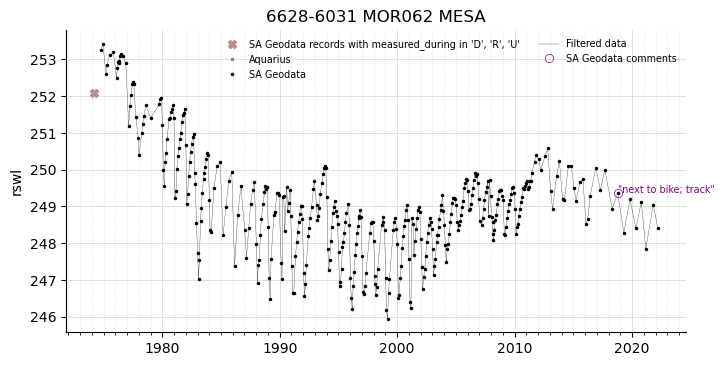

In [17]:
tn.plot_wl_data_validation(wls, removals, well_ids=["MOR062"])

Finally these two dataframes are saved:

- ``wls`` becomes the sheet "valid_data" worksheet in the "validated_data" workbook (SQLite table "validated_data__valid_data")
- ``removals`` -> "validated_data__invalid_data"

In [18]:
output_data = {"valid_data": wls, "invalid_data": removals}
resource.write_data_sheets("validated_data", output_data)

2022-05-20 16:28:36.839 | INFO     | wrap_technote.reporting:write_data_sheets:1322 - Writing data sheet to sqlite db at R:\DFW_CBD\Projects\Projects_Science\Water Resource Assessments\Annual\2021-22\Data\Barossa\Lower Aquifer\WL\data_Barossa_Lower_WL.sqlite...
2022-05-20 16:28:38.022 | INFO     | wrap_technote.reporting:write_data_sheets:1342 - Writing data spreadsheet to R:\DFW_CBD\Projects\Projects_Science\Water Resource Assessments\Annual\2021-22\Data\Barossa\Lower Aquifer\WL\validated_data_Barossa_Lower_WL.xlsx...
2022-05-20 16:28:38.032 | INFO     | wrap_technote.reporting:write_data_sheets:1346 - Adding last_run information to tables...
2022-05-20 16:28:44.450 | INFO     | wrap_technote.reporting:write_data_sheets:1346 - Adding last_run information to tables...
